In [42]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField as GAF
import torch
from fastai.vision import *

First I create a time series

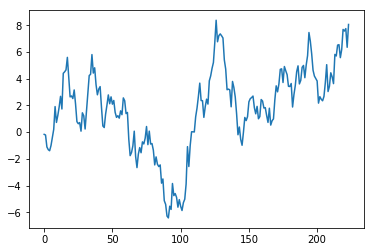

In [43]:
ts = np.random.randn(224).cumsum().reshape(1, -1)
plt.plot(ts[0])
plt.show()

We now scale that time series. There are 2 classes we'd like to differentiate. Class 0 is around 1x the original time series, and class 1 around 1.5x. We'd like to differentiate both using a Gramian Angular Field (GAF) transformation.

In [44]:
# Train
x1a = ts * .95
x1b = ts * 1.05
x2a = ts * 1.45
x2b = ts * 1.55
y1a = y1b = 0
y2a = y2b = 1
X_train = np.array([x1a, x1b, x2a, x2b])
y_train = np.array([y1a, y1b, y2a, y2b])
print(X_train.min(), X_train.max())

# Valid
x3a = ts * .9
x3b = ts * 1.08
x4a = ts * 1.52
x4b = ts * 1.57
X_valid = np.array([x3a, x3b, x4a ,x4b])
print(X_valid.min(), X_valid.max())

-9.959770432823102 12.982920108851284
-10.08828359969824 13.150441658642913


In [45]:
def GADF_encoder(ts, size=None, sample_range=None, overlapping=False):
    # ts: 2d (1, nsteps) time series
    # size: expected output size. The output size will be the min between defined size and ts n steps.
    # sample range: leave it to None to avoid a per sample normalization
    # overlapping: If True, reduce the size of each time series using PAA with possible overlapping windows
    assert ts.ndim == 2, 'ts ndim must be 2!'
    if size is None: size = ts.shape[-1]
    else: size = min(size, ts.shape[-1])
    encoder = GAF(
        image_size=size,
        sample_range=sample_range,
        method='d',
        overlapping=overlapping)
    return encoder.fit_transform(ts)

gadf = partial(GADF_encoder)

GAF takes values between (-1, 1). So we need to normalize the inputs. 
There is an argument in GAF that allows you to do that (sample_range). You can set it to (-1, 1) to normalize every sample.

class: 0


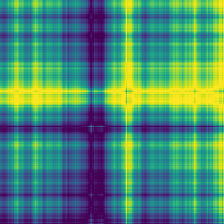

In [46]:
print('class:', y1a)
Image(torch.Tensor(gadf(x1a, sample_range=(-1, 1))))

class: 1


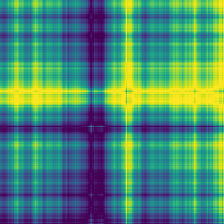

In [47]:
print('class:', y2a)
Image(torch.Tensor(gadf(x2a, sample_range=(-1, 1))))

But when we use it both samples look exactly the same!

When you set the sample_range argument to (-1, 1) for example, a per sample normalization occurs, and the differences between samples dissapear.

In [48]:
gadf(x1a, sample_range=(-1, 1))

array([[[ 0.      , -0.006533, -0.130455, -0.158543, ...,  0.950207,  0.966566,  0.823747,  0.990448],
        [ 0.006533,  0.      , -0.123974, -0.152089, ...,  0.952222,  0.968221,  0.827434,  0.991328],
        [ 0.130455,  0.123974,  0.      , -0.028384, ...,  0.982739,  0.991757,  0.89067 ,  0.999972],
        [ 0.158543,  0.152089,  0.028384,  0.      , ...,  0.987594,  0.994994,  0.903216,  0.999782],
        ...,
        [-0.950207, -0.952222, -0.982739, -0.987594, ...,  0.      ,  0.057553, -0.282031,  0.177625],
        [-0.966566, -0.968221, -0.991757, -0.994994, ..., -0.057553,  0.      , -0.33678 ,  0.120693],
        [-0.823747, -0.827434, -0.89067 , -0.903216, ...,  0.282031,  0.33678 ,  0.      ,  0.447961],
        [-0.990448, -0.991328, -0.999972, -0.999782, ..., -0.177625, -0.120693, -0.447961,  0.      ]]])

In [49]:
gadf(x2a, sample_range=(-1, 1))

array([[[ 0.      , -0.006533, -0.130455, -0.158543, ...,  0.950207,  0.966566,  0.823747,  0.990448],
        [ 0.006533,  0.      , -0.123974, -0.152089, ...,  0.952222,  0.968221,  0.827434,  0.991328],
        [ 0.130455,  0.123974,  0.      , -0.028384, ...,  0.982739,  0.991757,  0.89067 ,  0.999972],
        [ 0.158543,  0.152089,  0.028384,  0.      , ...,  0.987594,  0.994994,  0.903216,  0.999782],
        ...,
        [-0.950207, -0.952222, -0.982739, -0.987594, ...,  0.      ,  0.057553, -0.282031,  0.177625],
        [-0.966566, -0.968221, -0.991757, -0.994994, ..., -0.057553,  0.      , -0.33678 ,  0.120693],
        [-0.823747, -0.827434, -0.89067 , -0.903216, ...,  0.282031,  0.33678 ,  0.      ,  0.447961],
        [-0.990448, -0.991328, -0.999972, -0.999782, ..., -0.177625, -0.120693, -0.447961,  0.      ]]])

To avoid this you need to set this sample_range argument to None to disable the per sample normalization.

The key to ensure the difference between both classes is clear is in correctly scaling of the dataset!!!

You need to carefully normalize the train and test sets to a range (-1, 1) based on the train set.

In [50]:
# scale between (-1, 1)
X_train_scaled = (2 * (X_train - X_train.min()) / (X_train.max() - X_train.min())) - 1
print(X_train_scaled.min(), X_train_scaled.max())

X_valid_scaled = (2 * (X_valid - X_train.min()) / (X_train.max() - X_train.min())) - 1
print(X_valid_scaled.min(), X_valid_scaled.max())

-1.0 1.0
-1.0112029726105314 1.0146034790023721


It's important to cap the validation set to ensure no value is outside the (-1, 1) range.

In [51]:
X_valid_scaled = np.clip(X_valid_scaled, -1, 1)
print(X_valid_scaled.min(), X_valid_scaled.max())

-1.0 1.0


We'd like to be able to differentiate samples from class 0 from those from class 1.

But now the difference between classes will be maintained.

In [52]:
x1a_scaled = X_valid_scaled[0] # class 0
x2a_scaled = X_valid_scaled[2] # class 1

class: 0


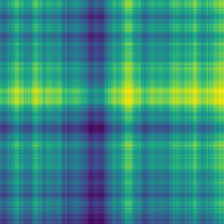

In [53]:
print('class:', y1a)
Image(torch.Tensor(gadf(x1a_scaled)))

class: 1


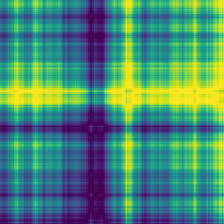

In [54]:
print('class:', y2a)
Image(torch.Tensor(gadf(x2a_scaled)))

Now it's super easy to tell the difference between both groups!